## Description:

This script creates Figure S2

In [1]:
import numpy as np
import netCDF4 as nc
import datetime as dt
import pandas as pd

from sklearn.cluster import KMeans
#import mpl_toolkits.mplot3d as mpl3d

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import cartopy
import cartopy.crs as ccrs

# for shapefile
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

%matplotlib inline

In [2]:
rootdir = '/raid1/chen423/serdp/archive/GRL2018/'

In [3]:
def get_nc_data(infile, var):
    tmpgroup = nc.Dataset(infile, 'r', format='NETCDF4')
    outdata = tmpgroup.variables[var][:]
    tmpgroup.close()
    return outdata

#### AR classification

In [35]:
def retrieve_ARclass(method):
    file_ffeature = rootdir+'data/AR_features/part2/%s.AR_events_feature.1981-2015.nc' % (method)
    ARfeature_full = get_nc_data(file_ffeature, 'AR_event_feature')
    file_class = rootdir+'data/AR_classification/AR_3class.%s.nc' % (method)
    AR_class_index = get_nc_data(file_class, 'ARclass_index')
    ARfeature_norm = get_nc_data(file_class, 'ARfeature_norm')
    
    return AR_class_index, ARfeature_full, ARfeature_norm

#### misc functions for data processing

In [6]:
def tindex_to_monthlyindex(index):
    stime = dt.datetime(1981,1,1,0)
    time_delta = dt.timedelta(hours=3*index)
    etime = stime + time_delta
    return (etime.year-1981)*12+etime.month-1  # -1 so it is conssistent with index that starts from 0 in 1981-01

In [7]:
def calc_lag_corraltion(clim_index, indata, lag=0):
    outdata = np.zeros(1080)
    full_len = clim_index.shape[0]
    for i in np.arange(1080):
        outdata[i] = np.corrcoef(clim_index[0:(full_len-lag)], indata[lag:(full_len),i])[0,1]
        
    return outdata

#### AR statistics

In [8]:
def sub_AR_monthly_nevents(cclass, AR_class_index, ARfeature_fulldata):
    outdata_counts = np.zeros(420)
    
    for i in np.arange(AR_class_index.shape[0]):
        mindex = tindex_to_monthlyindex(ARfeature_fulldata[i,8])
        if cclass=='whole':
            outdata_counts[mindex] = outdata_counts[mindex] + 1
        else:
            if AR_class_index[i]==cclass:
                outdata_counts[mindex] = outdata_counts[mindex] + 1
                
    outdata_sig = outdata_counts.copy()
    outdata_sig[outdata_counts>=1] = 1
    
    return outdata_counts, outdata_sig


def sub_AR_monthly_accum_IntDur(cclass, AR_class_index, ARfeature_fulldata):
    # accumulation of Intensity*Duration
    outdata = np.zeros(420)
    
    for i in np.arange(AR_class_index.shape[0]):
        mindex = tindex_to_monthlyindex(ARfeature_fulldata[i,8])
        if cclass=='whole':
            outdata[mindex] = outdata[mindex] + ARfeature_fulldata[i,3]*ARfeature_fulldata[i,7]
        else:
            if AR_class_index[i]==cclass:
                outdata[mindex] = outdata[mindex] + ARfeature_fulldata[i,3]*ARfeature_fulldata[i,7]
    
    return outdata


def sub_AR_monthly_accum_IntDurAre(cclass, AR_class_index, ARfeature_fulldata):
    # accumulation of Intensity*Duration*Area_land
    outdata = np.zeros(420)
    
    for i in np.arange(AR_class_index.shape[0]):
        mindex = tindex_to_monthlyindex(ARfeature_fulldata[i,8])
        if cclass=='whole':
            outdata[mindex] = outdata[mindex] + ARfeature_fulldata[i,3]*ARfeature_fulldata[i,7]*ARfeature_fulldata[i,1]
        else:
            if AR_class_index[i]==cclass:
                outdata[mindex] = outdata[mindex] + ARfeature_fulldata[i,3]*ARfeature_fulldata[i,7]*ARfeature_fulldata[i,1]
    
    return outdata


def sub_AR_monthly_accum_IntDurWid(cclass, AR_class_index, ARfeature_fulldata):
    # accumulation of Intensity*Duration*Width_coast
    outdata = np.zeros(420)
    
    for i in np.arange(AR_class_index.shape[0]):
        mindex = tindex_to_monthlyindex(ARfeature_fulldata[i,8])
        if cclass=='whole':
            outdata[mindex] = outdata[mindex] + ARfeature_fulldata[i,5]*ARfeature_fulldata[i,7]*ARfeature_fulldata[i,4]
        else:
            if AR_class_index[i]==cclass:
                outdata[mindex] = outdata[mindex] + ARfeature_fulldata[i,5]*ARfeature_fulldata[i,7]*ARfeature_fulldata[i,4]
    
    return outdata

In [37]:
def get_AR_stats(method):
    
    AR_class_index, ARfeature_full, ARfeature_norm = retrieve_ARclass(method)
    
    # on the first index:  0-2 are three AR types. 3 is the whole stats.
    AR_monthly_nevents = np.zeros((4,420))
    AR_monthly_sig = np.zeros((4,420))
    AR_monthly_nevents[3,:], AR_monthly_sig[3,:] = sub_AR_monthly_nevents('whole', AR_class_index, ARfeature_full)
    AR_monthly_nevents[0,:], AR_monthly_sig[0,:] = sub_AR_monthly_nevents(0, AR_class_index, ARfeature_full)
    AR_monthly_nevents[1,:], AR_monthly_sig[1,:] = sub_AR_monthly_nevents(1, AR_class_index, ARfeature_full)
    AR_monthly_nevents[2,:], AR_monthly_sig[2,:] = sub_AR_monthly_nevents(2, AR_class_index, ARfeature_full)

    AR_mon_acc_ida = np.zeros((4,420))
    AR_mon_acc_ida[3,:] = sub_AR_monthly_accum_IntDurAre('whole', AR_class_index, ARfeature_full)
    AR_mon_acc_ida[0,:] = sub_AR_monthly_accum_IntDurAre(0, AR_class_index, ARfeature_full)
    AR_mon_acc_ida[1,:] = sub_AR_monthly_accum_IntDurAre(1, AR_class_index, ARfeature_full)
    AR_mon_acc_ida[2,:] = sub_AR_monthly_accum_IntDurAre(2, AR_class_index, ARfeature_full)
    
    return AR_monthly_nevents, AR_monthly_sig, AR_mon_acc_ida

In [10]:
def sub_AR_daily_sig(cclass, AR_class_index, ARfeature_full, totaldays, lag=0):
    outdata = np.zeros(totaldays)
    for i in np.arange(AR_class_index.shape[0]):
        sindex = (dt.timedelta(hours=3*ARfeature_full[i,6])).days
        eindex = (dt.timedelta(hours=3*(ARfeature_full[i,6])+ARfeature_full[i,7])).days + lag
        if cclass=='whole':
            outdata[sindex:(eindex+1)] = np.ones(np.minimum(eindex-sindex+1, totaldays-sindex))
        else:
            if AR_class_index[i]==cclass:
                outdata[sindex:(eindex+1)] = np.ones(np.minimum(eindex-sindex+1, totaldays-sindex))
                
    return outdata

##### hydrological data processing

In [11]:
def calc_extreme_sum_monthly(dailyinput, pvalue):
    print(pvalue)
    tindex_daily = pd.date_range('1/1/1981', periods=dailyinput.shape[0])
    out_count = np.zeros((420,dailyinput.shape[1]))
    for i in np.arange(dailyinput.shape[1]):
        tmpdata = dailyinput[:,i].copy()
        threshold = np.percentile(tmpdata, pvalue*100)
        tmpdata[tmpdata<threshold]='NaN'
        tmpdata_tagged = pd.Series(tmpdata, index=tindex_daily)
        out_count[:,i] = tmpdata_tagged.resample('M').sum()
    return out_count

In [12]:
def calc_extreme_daily_sig(dailyinput, pvalue):
    print(pvalue)
    out_sig = np.zeros(dailyinput.shape)
    for i in np.arange(dailyinput.shape[1]):
        tmpdata = dailyinput[:,i].copy()
        threshold = np.percentile(tmpdata, pvalue*100)
        tmpdata[tmpdata<threshold]=0
        tmpdata[tmpdata>=threshold]=1
        out_sig[:,i] = tmpdata

    return out_sig

In [13]:
def gen_custom_positive_anomaly(indata, approach, pvalue=0.5):
    # indata: ()
    lens = indata.shape[0]
        
    outdata = np.zeros(indata.shape)
    
    for i in np.arange(indata.shape[1]):   # loop over basins
        
        if approach=='mean':
            baseline = np.mean(indata[:,i])
        elif approach=='percentile':
            baseline = np.percentile(indata[:,i], pvalue*100)
        
        outdata[:,i] = indata[:,i]-baseline
        
    outdata[outdata<0] = 0
    
    return outdata

#### computation of metrics

In [14]:
def compute_mean_correaltions_vlags(ARstats, hydrovar, lags=np.arange(7)):
    sbasin = 734
    ebasin = 1080
    npts = lags.shape[0]
    
    corr_stats = np.zeros((npts,5))
    
    for i in np.arange(npts):
        corrdata = calc_lag_corraltion(ARstats, hydrovar, lags[i])
        corr_stats[i,0] = np.min(corrdata[sbasin:ebasin])
        corr_stats[i,1] = np.percentile(corrdata[sbasin:ebasin], 25)
        corr_stats[i,2] = np.mean(corrdata[sbasin:ebasin])
        corr_stats[i,3] = np.percentile(corrdata[sbasin:ebasin], 75)
        corr_stats[i,4] = np.max(corrdata[sbasin:ebasin])
        
    return corr_stats

In [15]:
def calc_binary_scores(ARdata, hydrodata, metric):

    tmpdata = hydrodata+ARdata
    yy = (tmpdata==2).sum()
    nn = (tmpdata==0).sum()
    
    # yn, ARdata==1, hydrodata==0
    tmpdata = ARdata-hydrodata
    yn = (tmpdata==1).sum()
    ny = (tmpdata==-1).sum()


    if metric=='POD':
        outvalue = yy/(yy + ny)
    elif metric=='FAR':
        outvalue = yn/(yy + yn)
    elif metric=='Bias':
        outvalue = (yy + yn)/(yy + ny)
    elif metric=='HSS':
        outvalue = 2*(yy*nn-yn*ny)/((yy+ny)*(ny+nn)+(yy+yn)*(yn+nn))
    elif metric=='TS':
        outvalue = yy/(yy + ny + yn)
    elif metric=='GSS':
        ets_tmp = (yy + yn)*(yy + ny)/(yy + ny + yn + nn)
        outvalue= (yy - ets_tmp)/(yy + ny + yn - ets_tmp)
                                  
                                  
    return outvalue

In [16]:
def wrap_calc_binary_score(AR_daily_sig, dailyhydro, metric):
    
    outdata = np.zeros(dailyhydro.shape[1])
    
    for i in np.arange(dailyhydro.shape[1]):
        outdata[i] = calc_binary_scores(AR_daily_sig, dailyhydro[:,i], metric)
        
    return outdata

#### plotting

In [17]:
def plot_single_range(axes, xdata, ydatas, color, location, title, yrange=[-1,1]):
    axes.fill_between(xdata, ydatas[:,0], ydatas[:,4], facecolor=color, alpha=0.2)
    axes.fill_between(xdata, ydatas[:,1], ydatas[:,3], facecolor=color, alpha=0.6)
    axes.plot(ydatas[:,2], color, linewidth=4, alpha=1)
    axes.plot(np.arange(10), np.zeros(10), color='black', linestyle='--')
    axes.set_xlim(xrange)
    axes.set_ylim(yrange)
    
    # specific to locations
    if location=='l':
        axes.set_xticks([])
        axes.set_ylabel('corr. coeff.', size=12)
    elif location=='d':
        axes.set_xlabel('lags (month)', size=12)
        axes.set_yticks([])
    elif location=='ld':
        axes.set_xlabel('lags (month)', size=12)
        axes.set_ylabel('corr. coeff.', size=12)
    elif location=='o':
        axes.set_xticks([])
        axes.set_yticks([])
    elif location=='s':
        axes.set_ylabel('corr. coeff.', size=12)
        axes.set_xlabel('lag (month)', size=12)
        
    axes.text(xrange[1]/2, 0.8, title, horizontalalignment='center', size=10)

In [18]:
def panel_plot(axes, ARstats, hydrovar, lag):
    mapdata = calc_lag_corraltion(ARstats[0], hydrovar, lag)
    axes.plot(mapdata, color='royalblue', label='weak AR', zorder=0)

    mapdata = calc_lag_corraltion(ARstats[2], hydrovar, lag)
    axes.plot(mapdata, color='orange', label='prolonged AR', zorder=2)
    
    mapdata = calc_lag_corraltion(ARstats[1], hydrovar, lag)
    axes.plot(mapdata, color='lightseagreen', label='flash AR', zorder=1)
    
    axes.plot(np.arange(1100), np.zeros(1100), 'black', linestyle='--')

    axes.set_xlim(xrange)
    axes.set_ylim(yrange)
    axes.legend(loc='upper center', ncol=2, fontsize=10)

In [19]:
def panel_plot_1class(axes, ARstats, hydrovar, lag):
    mapdata = calc_lag_corraltion(ARstats[3], hydrovar, lag)
    axes.plot(mapdata, color='black', label='weak AR', alpha=0.8)
  
    axes.plot(np.arange(1100), np.zeros(1100), 'blue', linestyle='--')

    axes.set_xlim(xrange)
    axes.set_ylim(yrange)

In [20]:
reffile = rootdir+'data/ref_data/HU8_wUS.red005.nc'
HU8_mask = get_nc_data(reffile, 'Band1')
HU8_mask = get_nc_data(reffile, 'Band1')
lat = get_nc_data(reffile, 'lat')
lon = get_nc_data(reffile, 'lon')
hu8_list = np.genfromtxt(rootdir+'data/ref_data/hu8_list')[:,1]

lons, lats = np.meshgrid(lon, lat)

def generate_plot_data_matrix(indata):
    plot_data_matrix = np.ones(lons.shape)*9999

    for i in np.arange(1080):
        hu8id = hu8_list[i]
        plot_data_matrix[HU8_mask==hu8id] = indata[i]
    
    plot_data_matrix[plot_data_matrix==9999] = np.nan
        
    return plot_data_matrix

#### hydrological data

In [21]:
# all the daily data

dailyP_file = rootdir+'data/hydro_data/PRISM/PRISM.HUC8.P.1981-2015.daily.nc'
dailyP = get_nc_data(dailyP_file, 'P')

In [22]:
monthly_p95P_sum = calc_extreme_sum_monthly(dailyP, 0.95)
daily_p95P_sig = calc_extreme_daily_sig(dailyP, 0.95)

0.95
0.95


## plotting

#### fig2. plot relationship between AR and P. So no lag is needed

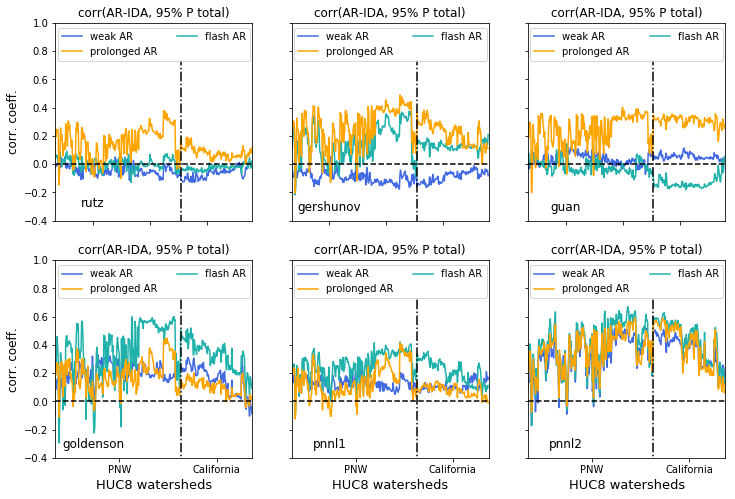

In [23]:
xrange = [734,1080]
lag = 0
yrange = [-0.4,1]

Pdata = monthly_p95P_sum
title = 'corr(AR-IDA, 95% P total)'

fig2 = plt.figure(figsize=(12,8))

method = 'rutz'
AR_monthly_nevents, AR_monthly_sig, AR_mon_acc_ida = get_AR_stats(method)
ax1 = plt.subplot(2,3,1)
panel_plot(ax1, AR_mon_acc_ida, Pdata, 0)
#panel_plot_1class(ax1, AR_mon_acc_ida, Pdata, 0)
ax1.plot((954,954), (-2,0.74), '-.', color='black')
ax1.text(800, -0.3, method, horizontalalignment='center', size=12)
ax1.set_title(title, size=12)
ax1.set_ylabel('corr. coeff.', size=12)
ax1.set_xticklabels([])
ax1.set_ylim(yrange)

method = 'gershunov'
AR_monthly_nevents, AR_monthly_sig, AR_mon_acc_ida = get_AR_stats(method)
ax2 = plt.subplot(2,3,2)
panel_plot(ax2, AR_mon_acc_ida, Pdata, 0)
#panel_plot_1class(ax2, AR_mon_acc_ida, Pdata, 0)
ax2.plot((954,954), (-2,0.74), '-.', color='black')
ax2.text(800, -0.33, method, horizontalalignment='center', size=12)
ax2.set_title(title, size=12)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_ylim(yrange)

method = 'guan'
AR_monthly_nevents, AR_monthly_sig, AR_mon_acc_ida = get_AR_stats(method)
ax3 = plt.subplot(2,3,3)
panel_plot(ax3, AR_mon_acc_ida, Pdata, 0)
#panel_plot_1class(ax3, AR_mon_acc_ida, Pdata, 0)
ax3.plot((954,954), (-2,0.74), '-.', color='black')
ax3.text(800, -0.33, method, horizontalalignment='center', size=12)
ax3.set_title(title, size=12)
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax3.set_ylim(yrange)

method = 'goldenson'
AR_monthly_nevents, AR_monthly_sig, AR_mon_acc_ida = get_AR_stats(method)
ax4 = plt.subplot(2,3,4)
panel_plot(ax4, AR_mon_acc_ida, Pdata, 0)
#panel_plot_1class(ax4, AR_mon_acc_ida, Pdata, 0)
ax4.plot((954,954), (-2,0.74), '-.', color='black')
ax4.text(800, -0.33, method, horizontalalignment='center', size=12)
ax4.set_title(title, size=12)
ax4.set_xticks([846,1017])
ax4.set_xlabel('HUC8 watersheds', size=13)
ax4.set_xticklabels({'PNW','California'})
ax4.set_ylabel('corr. coeff.', size=12)
ax4.set_ylim(yrange)

method = 'pnnl1'
AR_monthly_nevents, AR_monthly_sig, AR_mon_acc_ida = get_AR_stats(method)
ax5 = plt.subplot(2,3,5)
panel_plot(ax5, AR_mon_acc_ida, Pdata, 0)
#panel_plot_1class(ax5, AR_mon_acc_ida, Pdata, 0)
ax5.plot((954,954), (-2,0.74), '-.', color='black')
ax5.text(800, -0.33, method, horizontalalignment='center', size=12)
ax5.set_title(title, size=12)
ax5.set_xticks([846,1017])
ax5.set_xlabel('HUC8 watersheds', size=13)
ax5.set_xticklabels({'PNW','California'})
ax5.set_yticklabels([])
ax5.set_ylim(yrange)

method = 'pnnl2'
AR_monthly_nevents, AR_monthly_sig, AR_mon_acc_ida = get_AR_stats(method)
ax6 = plt.subplot(2,3,6)
panel_plot(ax6, AR_mon_acc_ida, Pdata, 0)
#panel_plot_1class(ax6, AR_mon_acc_ida, Pdata, 0)
ax6.plot((954,954), (-2,0.74), '-.', color='black')
ax6.text(800, -0.33, method, horizontalalignment='center', size=12)
ax6.set_title(title, size=12)
ax6.set_xticks([846,1017])
ax6.set_xlabel('HUC8 watersheds', size=13)
ax6.set_xticklabels({'PNW','California'})
ax6.set_yticklabels([])
ax6.set_ylim(yrange)

plt.show()

In [41]:
def visualize_wUS_map(axes, indata, location, title='', method='', ylim=[26,55], hu2bdy_flag=False, cmap='Blues', vmin=-0.6, vmax=0.6):
    
    axes.pcolormesh(lons, lats, indata, cmap=cmap, vmin=vmin, vmax=vmax)
    axes.set_xlim([-127, -100])
    axes.set_ylim(ylim)

    axes.add_feature(cartopy.feature.OCEAN, linewidth=0.5, facecolor='aliceblue', edgecolor='k', zorder=0)
    axes.add_feature(cartopy.feature.LAND, linewidth=0.5, facecolor='none', edgecolor='k', zorder=1)

    if hu2bdy_flag==True:
        shpfile = rootdir+'data/ref_data/HUC/HU2_wUS_R07-R18.shp'
        shape_feature = ShapelyFeature(Reader(shpfile).geometries(), ccrs.PlateCarree(), 
                                       facecolor='none', edgecolor='gray', linewidth=0.5)
        axes.add_feature(shape_feature)


    countries = cartopy.feature.NaturalEarthFeature(category='cultural', scale='10m', edgecolor='black', linewidth=0.25,\
                                                    facecolor='none', name='admin_0_countries')
    axes.add_feature(countries, zorder=3)

    gl = axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='-', alpha=1)
    gl.xlabels_top = location[0]
    gl.xlabels_bottom = location[1]
    gl.ylabels_left = location[2]
    gl.ylabels_right = location[3]
    gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(-180,-59,10))
    gl.ylocator = matplotlib.ticker.FixedLocator(np.arange(0,81,5))
    gl.xformatter = cartopy.mpl.gridliner.LONGITUDE_FORMATTER
    gl.yformatter = cartopy.mpl.gridliner.LATITUDE_FORMATTER
    
    
    axes.text(-108, 53, method, horizontalalignment='center', size=13, zorder=4)
    axes.set_title(title, size=13)

rutz done
gershunov done
guan done
goldenson done
pnnl1 done
pnnl2 done


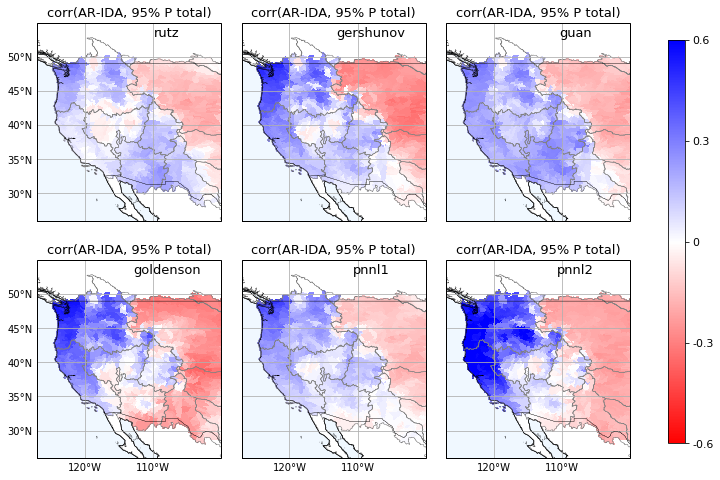

In [42]:
Pdata = monthly_p95P_sum

fig3 = plt.figure(figsize=(12,8))
ax1 = plt.subplot2grid((2,10), (0,0), colspan=3, projection=ccrs.PlateCarree())
ax2 = plt.subplot2grid((2,10), (0,3), colspan=3, projection=ccrs.PlateCarree())
ax3 = plt.subplot2grid((2,10), (0,6), colspan=3, projection=ccrs.PlateCarree())
ax4 = plt.subplot2grid((2,10), (1,0), colspan=3, projection=ccrs.PlateCarree())
ax5 = plt.subplot2grid((2,10), (1,3), colspan=3, projection=ccrs.PlateCarree())
ax6 = plt.subplot2grid((2,10), (1,6), colspan=3, projection=ccrs.PlateCarree())

title = 'corr(AR-IDA, 95% P total)'

method = 'rutz'
AR_monthly_nevents, AR_monthly_sig, AR_mon_acc_ida = get_AR_stats(method)
corrdata_raw = calc_lag_corraltion(AR_mon_acc_ida[3], Pdata, 0)
plot_data = generate_plot_data_matrix(corrdata_raw)
visualize_wUS_map(ax1, plot_data, location=[False,False,True,False], title=title, method=method, hu2bdy_flag=True, cmap='bwr_r')
print(method+' done')

method = 'gershunov'
AR_monthly_nevents, AR_monthly_sig, AR_mon_acc_ida = get_AR_stats(method)
corrdata_raw = calc_lag_corraltion(AR_mon_acc_ida[3], Pdata, 0)
plot_data = generate_plot_data_matrix(corrdata_raw)
visualize_wUS_map(ax2, plot_data, location=[False,False,False,False], title=title, method=method, hu2bdy_flag=True, cmap='bwr_r')
print(method+' done')

method = 'guan'
AR_monthly_nevents, AR_monthly_sig, AR_mon_acc_ida = get_AR_stats(method)
corrdata_raw = calc_lag_corraltion(AR_mon_acc_ida[3], Pdata, 0)
plot_data = generate_plot_data_matrix(corrdata_raw)
visualize_wUS_map(ax3, plot_data, location=[False,False,False,False], title=title, method=method, hu2bdy_flag=True, cmap='bwr_r')
print(method+' done')

method = 'goldenson'
AR_monthly_nevents, AR_monthly_sig, AR_mon_acc_ida = get_AR_stats(method)
corrdata_raw = calc_lag_corraltion(AR_mon_acc_ida[3], Pdata, 0)
plot_data = generate_plot_data_matrix(corrdata_raw)
visualize_wUS_map(ax4, plot_data, location=[False,True,True,False], title=title, method=method, hu2bdy_flag=True, cmap='bwr_r')
print(method+' done')

method = 'pnnl1'
AR_monthly_nevents, AR_monthly_sig, AR_mon_acc_ida = get_AR_stats(method)
corrdata_raw = calc_lag_corraltion(AR_mon_acc_ida[3], Pdata, 0)
plot_data = generate_plot_data_matrix(corrdata_raw)
visualize_wUS_map(ax5, plot_data, location=[False,True,False,False], title=title, method=method, hu2bdy_flag=True, cmap='bwr_r')
print(method+' done')

method = 'pnnl2'
AR_monthly_nevents, AR_monthly_sig, AR_mon_acc_ida = get_AR_stats(method)
corrdata_raw = calc_lag_corraltion(AR_mon_acc_ida[3], Pdata, 0)
plot_data = generate_plot_data_matrix(corrdata_raw)
visualize_wUS_map(ax6, plot_data, location=[False,True,False,False], title=title, method=method, hu2bdy_flag=True, cmap='bwr_r')
print(method+' done')

cbar_axes = fig3.add_axes([0.86, 0.15, 0.02, 0.7])
cb = matplotlib.colorbar.ColorbarBase(cbar_axes, cmap='bwr_r', ticks=[np.arange(0,1.01,0.25)], orientation='vertical')
cb.set_ticklabels(['-0.6', '-0.3', '0', '0.3', '0.6'])
cbar_axes.tick_params(labelsize=11)


plt.show()
plt.close()
del(fig3)

#### GSS/HSS plot

to check the possibility of using daily AR to forecast extreme P events

In [43]:
def panel_binary_score(axes, method, score, ylabel='', cat='none'):
    AR_class_index, ARfeature_full, ARfeature_norm = retrieve_ARclass(method)
    if cat=='single':
        AR_daily_sig = sub_AR_daily_sig('whole', AR_class_index, ARfeature_full, totaldays, lag=0)
        score_p95Pd_AR = wrap_calc_binary_score(AR_daily_sig, daily_p95P_sig, score)
        axes.plot(score_p90Pd_AR, color='grey', label='90% P, AR')
        axes.plot(score_p95Pd_AR, color='grey', linestyle='--', label='95% P, AR')
    else:
        AR0_daily_sig = sub_AR_daily_sig(0, AR_class_index, ARfeature_full, totaldays, lag=0)
        AR1_daily_sig = sub_AR_daily_sig(1, AR_class_index, ARfeature_full, totaldays, lag=0)
        AR2_daily_sig = sub_AR_daily_sig(2, AR_class_index, ARfeature_full, totaldays, lag=0)
    
        score_p95Pd_AR0 = wrap_calc_binary_score(AR0_daily_sig, daily_p95P_sig, score)
        score_p95Pd_AR1 = wrap_calc_binary_score(AR1_daily_sig, daily_p95P_sig, score)
        score_p95Pd_AR2 = wrap_calc_binary_score(AR2_daily_sig, daily_p95P_sig, score)
    
        axes.plot(score_p95Pd_AR0, color='royalblue', linestyle='--', label='95% P, w.AR')
        axes.plot(score_p95Pd_AR1, color='lightseagreen', linestyle='--', label='95% P, f.AR')
        axes.plot(score_p95Pd_AR2, color='orange', linestyle='--', label='95% P, p.AR')

    axes.plot(np.arange(1080), np.zeros(1080), 'k')
    
    if score=='HSS':
        axes.plot((954,954), (-2,0.45), '-.', color='black')
    elif score=='GSS':
        axes.plot((954,954), (-2,0.25), '-.', color='black')
    
    axes.set_xlim(xrange)
    axes.set_ylim(yrange)

    axes.legend(loc='upper center', ncol=2, fontsize=9, frameon=False)

    axes.set_ylabel(ylabel, size=13)
    axes.set_title('%s : %s' % (score, method), size=14)

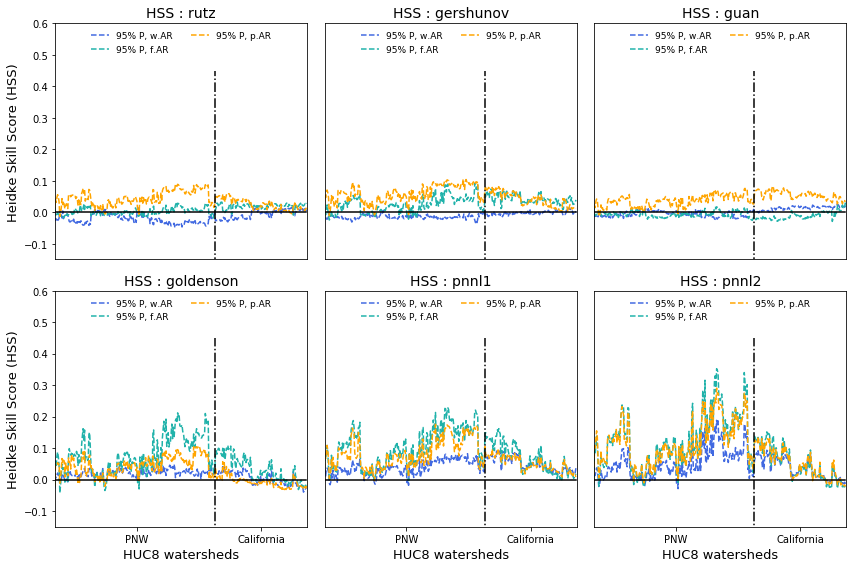

In [44]:
xrange = [734,1080]
totaldays = dailyP.shape[0]

#score = 'GSS'
#ylabel = 'Gilbert Skill Score (GSS)'
#yrange = [-0.15, 0.35] # GSS

score = 'HSS'
ylabel = 'Heidke Skill Score (HSS)'
yrange = [-0.15,0.6] # HSS

fig4 = plt.figure(figsize=(12,8))
ax1 = plt.subplot2grid((2,3),(0,0))
ax2 = plt.subplot2grid((2,3),(0,1))
ax3 = plt.subplot2grid((2,3),(0,2))
ax4 = plt.subplot2grid((2,3),(1,0))
ax5 = plt.subplot2grid((2,3),(1,1))
ax6 = plt.subplot2grid((2,3),(1,2))


panel_binary_score(ax1, 'rutz', score, ylabel=ylabel, cat='none')
panel_binary_score(ax2, 'gershunov', score, cat='none')
panel_binary_score(ax3, 'guan', score, cat='none')
panel_binary_score(ax4, 'goldenson', score, ylabel=ylabel, cat='none')
panel_binary_score(ax5, 'pnnl1', score, cat='none')
panel_binary_score(ax6, 'pnnl2', score, cat='none')

ax1.set_xticks([])
ax2.set_xticks([])
ax3.set_xticks([])
ax2.set_yticks([])
ax3.set_yticks([])
ax5.set_yticks([])
ax6.set_yticks([])
ax4.set_xticks([846,1017])
ax4.set_xticklabels({'PNW','California'})
ax4.set_xlabel('HUC8 watersheds', size=13)
ax5.set_xticks([846,1017])
ax5.set_xticklabels({'PNW','California'})
ax5.set_xlabel('HUC8 watersheds', size=13)
ax6.set_xticks([846,1017])
ax6.set_xticklabels({'PNW','California'})
ax6.set_xlabel('HUC8 watersheds', size=13)

plt.tight_layout()

plt.show()

#### GSS/HSS map

see which regions are more predicable based on AR

In [31]:
def crt_MS_norm_colormap(cmapname):
    full_info = {'precip3_9segs':['#ffffff', '#b5c9ff', '#7f96ff', '#0063ff', '#00c633', '#96ff00', '#ffff00', '#ffa000', '#ff1900']
                    
    }
    
    if cmapname=='demo':
        print(full_info.get('demo'))
    else:
        return matplotlib.colors.ListedColormap(full_info.get(cmapname))

In [34]:
def visualize_wUS_map_full_cus_cbar(axes, indata, location, cmap, norm, title='', method='', ylim=[26,55], hu2bdy_flag=False):
    
    axes.pcolormesh(lons, lats, indata, cmap=cmap, norm=norm)
    axes.set_xlim([-127, -100])
    axes.set_ylim(ylim)

    axes.add_feature(cartopy.feature.OCEAN, linewidth=0.5, facecolor='aliceblue', edgecolor='k', zorder=0)
    axes.add_feature(cartopy.feature.LAND, linewidth=0.5, facecolor='none', edgecolor='k', zorder=1)

    if hu2bdy_flag==True:
        shpfile = rootdir+'data/ref_data/HUC/HU2_wUS_R07-R18.shp'
        shape_feature = ShapelyFeature(Reader(shpfile).geometries(), ccrs.PlateCarree(), 
                                       facecolor='none', edgecolor='gray', linewidth=0.5)
        axes.add_feature(shape_feature)


    countries = cartopy.feature.NaturalEarthFeature(category='cultural', scale='10m', edgecolor='black', linewidth=0.25,\
                                                    facecolor='none', name='admin_0_countries')
    axes.add_feature(countries, zorder=3)

    gl = axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='-', alpha=1)
    gl.xlabels_top = location[0]
    gl.xlabels_bottom = location[1]
    gl.ylabels_left = location[2]
    gl.ylabels_right = location[3]
    gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(-180,-59,10))
    gl.ylocator = matplotlib.ticker.FixedLocator(np.arange(0,81,5))
    gl.xformatter = cartopy.mpl.gridliner.LONGITUDE_FORMATTER
    gl.yformatter = cartopy.mpl.gridliner.LATITUDE_FORMATTER
    
    
    axes.text(-108, 53, method, horizontalalignment='center', size=13, zorder=4)
    axes.set_title(title, size=13)

rutz done
gershunov done
guan done
goldenson done
pnnl1 done
pnnl2 done


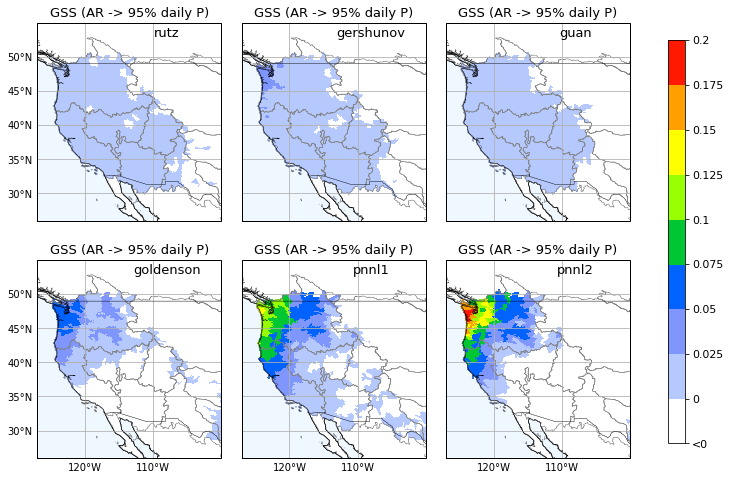

In [45]:
totaldays = dailyP.shape[0]

score = 'GSS'
title = 'GSS (AR -> 95% daily P)'

fig5 = plt.figure(figsize=(12,8))
ax1 = plt.subplot2grid((2,10), (0,0), colspan=3, projection=ccrs.PlateCarree())
ax2 = plt.subplot2grid((2,10), (0,3), colspan=3, projection=ccrs.PlateCarree())
ax3 = plt.subplot2grid((2,10), (0,6), colspan=3, projection=ccrs.PlateCarree())
ax4 = plt.subplot2grid((2,10), (1,0), colspan=3, projection=ccrs.PlateCarree())
ax5 = plt.subplot2grid((2,10), (1,3), colspan=3, projection=ccrs.PlateCarree())
ax6 = plt.subplot2grid((2,10), (1,6), colspan=3, projection=ccrs.PlateCarree())

cmap = crt_MS_norm_colormap('precip3_9segs')
norm = matplotlib.colors.Normalize(vmin=-0.025,vmax=0.2)


method = 'rutz'
AR_class_index, ARfeature_full, ARfeature_norm = retrieve_ARclass(method)
AR_daily_sig = sub_AR_daily_sig('whole', AR_class_index, ARfeature_full, totaldays, lag=0)
scoredata = wrap_calc_binary_score(AR_daily_sig, daily_p95P_sig, score)
scoredata[scoredata<0] = -0.01
plot_data = generate_plot_data_matrix(scoredata)
visualize_wUS_map_full_cus_cbar(ax1, plot_data, location=[False,False,True,False], cmap=cmap, norm=norm,
                  title=title, method=method, hu2bdy_flag=True)
print(method+' done')

method = 'gershunov'
AR_class_index, ARfeature_full, ARfeature_norm = retrieve_ARclass(method)
AR_daily_sig = sub_AR_daily_sig('whole', AR_class_index, ARfeature_full, totaldays, lag=0)
scoredata = wrap_calc_binary_score(AR_daily_sig, daily_p95P_sig, score)
scoredata[scoredata<0] = -0.01
plot_data = generate_plot_data_matrix(scoredata)
visualize_wUS_map_full_cus_cbar(ax2, plot_data, location=[False,False,False,False], cmap=cmap, norm=norm,
                  title=title, method=method, hu2bdy_flag=True)
print(method+' done')

method = 'guan'
AR_class_index, ARfeature_full, ARfeature_norm = retrieve_ARclass(method)
AR_daily_sig = sub_AR_daily_sig('whole', AR_class_index, ARfeature_full, totaldays, lag=0)
scoredata = wrap_calc_binary_score(AR_daily_sig, daily_p95P_sig, score)
scoredata[scoredata<0] = -0.01
plot_data = generate_plot_data_matrix(scoredata)
visualize_wUS_map_full_cus_cbar(ax3, plot_data, location=[False,False,False,False], cmap=cmap, norm=norm,
                  title=title, method=method, hu2bdy_flag=True)
print(method+' done')

method = 'goldenson'
AR_class_index, ARfeature_full, ARfeature_norm = retrieve_ARclass(method)
AR_daily_sig = sub_AR_daily_sig('whole', AR_class_index, ARfeature_full, totaldays, lag=0)
scoredata = wrap_calc_binary_score(AR_daily_sig, daily_p95P_sig, score)
scoredata[scoredata<0] = -0.01
plot_data = generate_plot_data_matrix(scoredata)
visualize_wUS_map_full_cus_cbar(ax4, plot_data, location=[False,True,True,False], cmap=cmap, norm=norm,
                  title=title, method=method, hu2bdy_flag=True)
print(method+' done')

method = 'pnnl1'
AR_class_index, ARfeature_full, ARfeature_norm = retrieve_ARclass(method)
AR_daily_sig = sub_AR_daily_sig('whole', AR_class_index, ARfeature_full, totaldays, lag=0)
scoredata = wrap_calc_binary_score(AR_daily_sig, daily_p95P_sig, score)
scoredata[scoredata<0] = -0.01
plot_data = generate_plot_data_matrix(scoredata)
visualize_wUS_map_full_cus_cbar(ax5, plot_data, location=[False,True,False,False], cmap=cmap, norm=norm,
                  title=title, method=method, hu2bdy_flag=True)
print(method+' done')

method = 'pnnl2'
AR_class_index, ARfeature_full, ARfeature_norm = retrieve_ARclass(method)
AR_daily_sig = sub_AR_daily_sig('whole', AR_class_index, ARfeature_full, totaldays, lag=0)
scoredata = wrap_calc_binary_score(AR_daily_sig, daily_p95P_sig, score)
scoredata[scoredata<0] = -0.01
plot_data = generate_plot_data_matrix(scoredata)
visualize_wUS_map_full_cus_cbar(ax6, plot_data, location=[False,True,False,False], cmap=cmap, norm=norm,
                  title=title, method=method, hu2bdy_flag=True)
print(method+' done')

cbar_axes = fig5.add_axes([0.86, 0.15, 0.02, 0.7])
cb = matplotlib.colorbar.ColorbarBase(cbar_axes, cmap=cmap, ticks=[np.arange(0,1.01,1/9)], orientation='vertical')
#cb.set_ticklabels(['<0', '0', '0.05', '0.1', '0.15', '0.2', '0.25', '0.3', '0.35', '0.4'])
cb.set_ticklabels(['<0', '0', '0.025', '0.05', '0.075', '0.1', '0.125', '0.15', '0.175', '0.2'])
cbar_axes.tick_params(labelsize=11)


plt.show()

## verify PRISM and WRF P

In [46]:
# all the daily data
dailyP_file = rootdir+'data/hydro_data/PRISM/PRISM.HUC8.P.1981-2015.daily.nc'
dailyP_PRISM = get_nc_data(dailyP_file, 'P')

dailyP_file = rootdir+'data/hydro_data/WRF/NARR_hist.HUC8.P.nc'
dailyP_WRF = get_nc_data(dailyP_file, 'P')

In [47]:
p95P_PRISM = np.percentile(dailyP_PRISM, 95,axis=0)
p95P_WRF = np.percentile(dailyP_WRF, 95, axis=0)

mean_PRISM = np.mean(dailyP_PRISM, axis=0)
mean_WRF = np.mean(dailyP_WRF, axis=0)

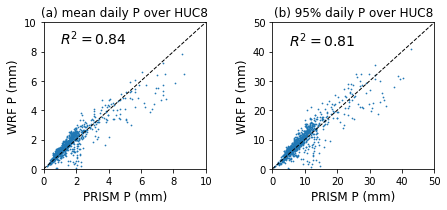

In [48]:
fig6 = plt.figure(figsize=(7,3))

ax1 = plt.subplot2grid((10,7), (0,0), rowspan=9,colspan=3)
ax1.scatter(mean_PRISM, mean_WRF, s=0.5)
ax1.plot(np.arange(11), np.arange(11), linewidth=1, linestyle='--', color='black')
ax1.set_xlim([0,10])
ax1.set_ylim([0,10])
ax1.set_xlabel('PRISM P (mm)', size=12)
ax1.set_ylabel('WRF P (mm)', size=12)
ax1.set_title('(a) mean daily P over HUC8', size=12)
ax1.text(1,8.5, r'$R^2=%.2f$' % (np.corrcoef(mean_PRISM, mean_WRF)[0,1]**2), size=14)

ax2 = plt.subplot2grid((10,7), (0,4), rowspan=9, colspan=3)
ax2.scatter(p95P_PRISM, p95P_WRF, s=0.5)
ax2.plot(np.arange(51), np.arange(51), linewidth=1, linestyle='--', color='black')
ax2.set_xlim([0,50])
ax2.set_ylim([0,50])
ax2.set_xlabel('PRISM P (mm)', size=12)
ax2.set_ylabel('WRF P (mm)', size=12)
ax2.set_title('(b) 95% daily P over HUC8', size=12)
ax2.text(5,42, r'$R^2=%.2f$' % (np.corrcoef(p95P_PRISM, p95P_WRF)[0,1]**2), size=14)

#fig6.savefig(rootdir+'plots/figS2.png', dpi=600)
plt.show()
plt.close()
del(fig6)

In [42]:
print(np.corrcoef(mean_PRISM, mean_WRF)[0,1])
print(np.corrcoef(p95P_PRISM, p95P_WRF)[0,1])

0.915780603192
0.900390699319
